(Intro:introduction)=
# Introduction

## What is Sensor Fusion?
Sensor fusion is the concept of merging information from external sensors into a common estimate of what is known as the *system state*. The system in this book will typically be some kind of robotic platform that is equipped with sensors such as, e.g. odometer, GNSS receiver and/or lidar. The sensors are typically navigation sensors, thus they provide geometric information with respect to their surroundings (e.g. distance, odometry, position and so on). The information from the sensors may have different sampling rates, noise characteristics and they are in general provided at different points in time.

The main workhorse for merging this kind of information in most engineering applications is undoubtly the *Kalman Filter*. In this book we will introduce the classical Discrete Kalman Filter as estimator in order to exemplify the principle ideas to begin with, and then progress towards more advanced estimators such as e.g. Extended Kalman Filter, Uncented Kalman Filter and the Particle Filter when needed.

## What is a Filter?

![coffee](fig/coffee.jpg)

As with making a cup of coffee - a filter is a device intended to separate things from one another. In the coffee case the two things to be seprated are coffee grounds and coffee. However, in the scope of this book the two "things" to be separated are *signal* and *noise*.

So, when we talk about a filter in this book is in practice just another word for an *recursive algorithm* that separates signal from noise. Or more specifically, an algorithm that is able to provide estimates of the *system state* based on the knowledge of the previous system state merged with new information from the sensors.

(Intro:mean_and_variance)=
## Mean and Variance
Just to show the idea behind the filter being an recursive algorithm, let's start with the simple example of recursively computing the *mean* and *standard error* of a random set of numbers. Assume that we have a system that doesn't change with time, thus being what we would call a *static system*. In the vocabulary of the Kalman Filter we would say that the systems dynamic model is just a constant.

The measurement in this example is the distance to a wall measured by a robot being at rest. The distance is measured repeatedly over time with a laser scanner. Within this simple 1D world frame, the distance is equal to the position of the robot.

```{figure} fig/laserscan.png
:name: laserscan1

Laser scanner
```

For simplicity, since we do not know anything about any digital filters yet, we choose first to estimate the position as the sample mean of all the measurements. This will now become our *measurement model*, i.e. how the measurements relates to the *system state*. It will look something like this:

$$
\bar x = \frac{1}{n} \sum_{i=1}^n x_i
$$

To perform an implementation in Python, let us just make a list of 10 random numbers and set them to be our measurements from the laser scanner.

```{note}
The sample mean, standard deviation and standard error can easily be computed based on the functions *mean* and *std* from Python's numpy library.
```

In [1]:
# Compute sample mean, standard deviation and standard error

# Import
from numpy import mean, std, sqrt

# Measurements
x = [51.34, 48.17, 49.02, 50.97, 51.23, 50.72, 48.95, 49.45, 52.07, 50.52]

# Number of measurements
N = len(x)

mu = mean(x)
sd = std(x, ddof=1)
se = sd/sqrt(N)

print(f"Estimated position: {mu:.2f} m")
print(f"Standard deviation: {sd:.2f} m")
print(f"Standard error:     {se:.2f} m")

Estimated position: 50.24 m
Standard deviation: 1.27 m
Standard error:     0.40 m


```{note}
In Python's numpy library the degrees of freedom (ddof) is 0 by default. We therefore need to specify ddof=1 to account for the choice of the sample mean as an estimate of the unknown population mean.
```

This is a perfectly reasonable estimate of the unknown position and the corresponding precision, however the main problem is that we have to wait until all the measurements are available before we can compute the position estimate. Usually we do not want to wait for all the measurements to be available, instead we want to calculate the position estimate as soon as the measurements arrive from the laser scanner.

## Recursive Mean and Variance
To do this we need to modify the equation a little bit to be able to update the current position estimate as the new measurements arrive. So, let us derive the mean value from the definition above:

$$
\begin{align}
  \bar{x}_{n} =& \frac{1}{n}\sum_{i=1}^n x_i \\
              =& \bar{x}_{n-1} + \frac{1}{n}(x_n-\bar{x}_{n-1})
\end{align}
$$

Voila! now we have a recursive algorithm to compute the mean position. As seen above, the mean can now be calculated recursively as the previous mean plus the weighted contribution of the new measurement.

```{note}
This is essentially what a Kalman Filter is doing, except that it will also contain a dynamic model in addition to the measurement model.
```

Let us first try our new algorithm with the measurements from the laser scanner.

In [2]:
# Compute recursive mean

# Measurements
x = [51.34, 48.17, 49.02, 50.97, 51.23, 50.72, 48.95, 49.45, 52.07, 50.52]

# Inital estimate
x_bar = 0

# Number of measurements
N = len(x)

# Initialize result lists
pos = []; meas = []

# Main loop
for n in range(1, N + 1):
    
    # Previous value
    x_barp = x_bar
    
    # Recursive mean
    x_bar = x_barp + 1/n*(x[n - 1] - x_barp)
    
    # Accumulate result lists
    pos.append(x_bar)
    meas.append(x[n - 1])

print("Measurement        : " + ' '.join(f'{meas:.2f}' for meas in meas))
print("Estimated position : " + ' '.join(f'{pos:.2f}' for pos in pos))

Measurement        : 51.34 48.17 49.02 50.97 51.23 50.72 48.95 49.45 52.07 50.52
Estimated position : 51.34 49.76 49.51 49.88 50.15 50.24 50.06 49.98 50.21 50.24


```{note}
All Python lists and arrays are zero indexed, therefore the very first element always has index 0
```

Unlike the sample mean, the recursive mean can make use of the new measurements once they are available and provide an estimate of the unknown position. Also note that, in the end when all the measurements are available, the sample mean and the recursive mean will, as expected, provide the exact same estimate of the unknown position.

### Plotting the results
When working with recursive algorithms it is often much easier to get an overall impression of the filter performance by plotting the estimated values over time. While it might seem unnecessary to plot the results with this simple example, it is still good practice to do so and it will help you solve many of the problems you eventually will run into as the datasets becomes much larger.

So, lets briefly show how to plot the main results from this simple example.

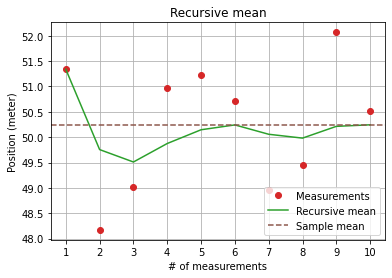

In [3]:
# Plotting the results

# Import
from numpy import arange
import matplotlib.pyplot as plt

# Defining x-axis
n = arange(1, N + 1)

# Plot result
plt.title("Recursive mean")
plt.plot(n, meas, color='tab:red', marker='o', linestyle='none', label='Measurements')
plt.plot(n, pos, color='tab:green', label='Recursive mean')
plt.axhline(y=x_bar, color='tab:brown', linestyle='dashed', label='Sample mean')
plt.xlabel("# of measurements"); plt.xticks(n)
plt.ylabel("Position (meter)")
plt.legend(loc='lower right')
plt.grid()
plt.show()

## Error Analysis
The square root of the *variance* is called the *standard deviation*. Both quantities are very useful statistical units and also quite similar as they both contain information about the signal noise. However, note that only standard deviation will have the same units as the signal itself, thus it will usually be easier to interpret when quantifying noise.

Another important quantity to compute the so called *standard error*. This is the standard deviation of the estimated mean position that we just computed. Note that usually we cannot compute the true position error as this would require knowledge of the true position, which we do not have. However, let us for now define $\bar{x}_n$ to be our "true" position and begin with defining the sample *variance*.

$$
s_n^2 = \frac{1}{n - 1} \sum_{i=1}^n (x_i - \bar{x}_n)^2
$$

Let us then derive the recursive variance by from the definition. This is what is known as Wellfords algorithm {cite}`wellford1962`:

$$
\begin{align}
  s_n^2 =& \frac{1}{n - 1} \sum_{i=1}^n (x_i - \bar{x}_n)^2 \\
        =& s_{n-1}^2 + \frac{1}{n}(x_n - \bar{x}_{n-1})^2 - \frac{1}{n-1}s_{n-1}^2
\end{align}
$$


Now that we have the sample variance, it is straigth forward to compute the standard error as the standard deviation divided by the square root of the number of observations.

$$
\begin{split}
  \sigma_{\bar{x}_n} = & \frac{s_n}{\sqrt{n}}
\end{split}
$$

Now let us plot the standard deviation together with the standard error for the estimated position.

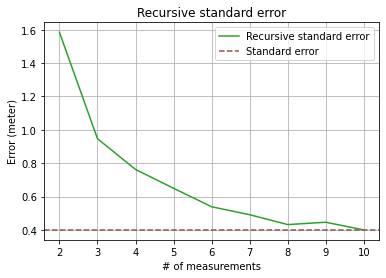

In [4]:
# Import
from numpy import arange, sqrt
import matplotlib.pyplot as plt

# Measurements
x = [51.34, 48.17, 49.02, 50.97, 51.23, 50.72, 48.95, 49.45, 52.07, 50.52]

# Inital estimate
x_bar = 0; s2 = 0

# Number of measurements
N = len(x)

# Initialize result lists
sd = []

# Main loop
for n in range(1, N + 1):
    
    # Previous values
    x_barp = x_bar
    s2p = s2
    
    # Recursive mean
    x_bar = x_barp + 1/n*(x[n - 1] - x_barp)
    
    if n > 1:
        
        # Recursive variance
        s2 = s2p + 1/n*(x[n - 1] - x_barp)**2 - 1/(n - 1)*s2p
        
        # Accumulate result lists
        sd.append(sqrt(s2/n))
                         
# Defining x-axis
n = arange(2, N + 1)

# Plot results
plt.title("Recursive standard error")
plt.plot(n, sd, color='tab:green', label='Recursive standard error')
plt.axhline(y=se, color='tab:brown', linestyle='dashed', label='Standard error')
plt.xlabel("# of measurements")
plt.ylabel('Error (meter)')
plt.legend(loc='upper right')
plt.grid()
plt.show()

Note how the estimated error converge towards the standard error as more measurements contributes to compute the sample mean. In order to illustrate both the estimated values together with their corresponding errors, it is sometimes convenient to plot all the information together in the same plot. It may look something like this.

```{note}
When Working with Python lists or arrays, we may use the function *negative* to change sign for all elements in the list.
```

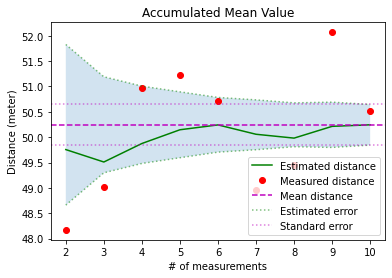

In [5]:
# Import
from numpy import negative
import matplotlib.pyplot as plt

# Plot results
plt.title("Accumulated Mean Value")
plt.plot(n, pos[1:], color='g', label='Estimated distance')
plt.plot(n, meas[1:], color='r', marker='o', linestyle='none', label='Measured distance')
plt.axhline(y=mu, color='m', linestyle='dashed', label='Mean distance')
plt.xlabel("# of measurements")
plt.ylabel("Distance (meter)")

plt.plot(n, mu + sd, alpha=0.5, color='g', linestyle='dotted', label='Estimated error')
plt.plot(n, mu + negative(sd), alpha=0.5, color='g', linestyle='dotted')
plt.fill_between(n, mu + sd, mu + negative(sd), alpha=0.2)
plt.axhline(y=mu + se, alpha=0.5, color='m', linestyle='dotted',label='Standard error')
plt.axhline(y=mu - se, alpha=0.5, color='m', linestyle='dotted')

plt.legend(loc='lower right')
plt.show()

So, this is it? No, there is a lot more to filtering than this, but still this very simple example of calculating the recursive mean and standard error actually captures the idea of sequential algorithms and the ideas behind it. Please make sure you fully understand this simple example before you proceed to the next chapter.

## Summary
In this brief introduction we have been introduced to the concept of filtering and how this is closely related to recursive algorithms. We have derived two recursive algorithms for computing the mean and variance of a list of numbers, thus making us able to continously update our estimates as new measurement become available.

For the computational example we have introduced recursive algorithms for computing the mean and variance together with the standard error.

$$
\begin{align}
  \bar{x}_n =& \bar{x}_{n-1} + \frac{1}{n}(x_n-\bar{x}_{n-1})\\
  s^2_n =& s_{n-1}^2 + \frac{1}{n}(x_n - \bar{x}_{n-1})^2 - \frac{1}{n-1}s_{n-1}^2\\
  \sigma_{\bar{x}_n} = & \frac{s_n}{\sqrt{n}}
\end{align}
$$

Let's move on to some linear algabra and the matrix notation...